In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
pd.options.display.max_rows = 999
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

In [2]:
# Setup the figures
style='talk'
execfile('/Users/ttshimiz/Dropbox/Research/figure_setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Upload the fits for the BAT AGN
bat_casey = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Get rid of the galaxies that are radio-loud and/or have bad fits
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['LBAT'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12)

In [4]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)
hrs_casey_undetected = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_hrs.csv', index_col=0)
hrs_all = pd.concat([hrs_casey, hrs_casey_undetected])

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)

# Remove the BAT AGN from the HRS Sample
hrs_all = hrs_all.drop([4,144,288,296])
hrs_all['Mstar']= hrs_info['logMstart']

In [11]:
# Upload the KINGFISH fits
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv', index_col=0)

# Upload teh KINGFISH info
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt', index_col=0, delimiter='\t')

# Identify the dwarf galaxies as any galaxy with stellar mass < 10^8 Msun
kf_dwarfs = kf_info['Mstar'] < 9.47
kf_agn = (kf_info['Nuc. Type'] == 'AGN') | (kf_info['Nuc. Type'] == 'SF/AGN')
kf_casey['Mstar'] = kf_info['Mstar']

In [5]:
# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_casey['Mstar'] = -0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) + np.log10(bat_koss['SDSS_Li']/3.846e33)
print 'Number of BAT AGN with reliable stellar mass estimates = '+ str(len(bat_casey['Mstar'].dropna()))

Number of BAT AGN with reliable stellar mass estimates = 122


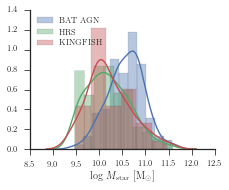

In [13]:
fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
sn.distplot(bat_casey['Mstar'].dropna(), label='BAT AGN')
sn.distplot(hrs_info['logMstart'][hrs_info['logMstart'] >= 9.47].dropna(), label='HRS')
sn.distplot(kf_info['Mstar'][~kf_dwarfs].dropna(), label='KINGFISH')
plt.xlabel(r'$\log\,M_{\rm star}$ [M$_{\odot}$]')
plt.legend(loc='upper left')
sn.despine()
plt.savefig(figsave_dir+'stellar_mass_comp_nolowmass.pdf', bbox_inches='tight')

In [61]:
bat_mstar = bat_casey['Mstar'].dropna()
mass_select_hrs = pd.DataFrame(index=bat_mstar.index, columns=['BAT Mstar', 'HRS ID', 'HRS Mstar'])
mass_select_hrs['BAT Mstar'] = bat_mstar
chosen = []
for n in bat_mstar.index:
    
    match_ids = hrs_all.loc[np.abs(hrs_all['Mstar'] - bat_mstar.loc[n]) < 0.15].index.values
    unique_match_ids = []
    for mi in match_ids:
        if ~np.any(mi == chosen):
            unique_match_ids.append(mi)
            
    if len(unique_match_ids) != 0:
        match_id = unique_match_ids[np.random.randint(len(unique_match_ids))]
    else:
        match_id = match_ids[np.random.randint(len(match_ids))]
    chosen.append(match_id)
    mass_select_hrs.loc[n, 'HRS ID'] = match_id
    mass_select_hrs.loc[n, 'HRS Mstar'] = hrs_info.loc[match_id, 'logMstart']

In [62]:
match_ids

array([102, 113, 114, 117, 129, 141, 162, 173, 194, 204, 216,  22, 260,
       285, 295,  46,  69,  77,   7,  93,  71, 175, 218, 316])

In [42]:
unique_match_ids

[93, 103, 141, 173, 175, 204, 216]

In [63]:
len(np.unique(mass_select_hrs['HRS ID'].values))

97

In [6]:
mass_select = pd.read_csv('mass_selected_hrs_ids.csv', index_col=0)
hrs_mass_select = pd.DataFrame(index=mass_select.index, columns=hrs_all.columns)

for n in mass_select.index:
    
    hrs_mass_select.loc[n] = hrs_all.loc[np.int(mass_select.loc[n, 'HRS ID'])]
    hrs_mass_select.loc[n, 'HRS ID'] = np.int(mass_select.loc[n, 'HRS ID'])

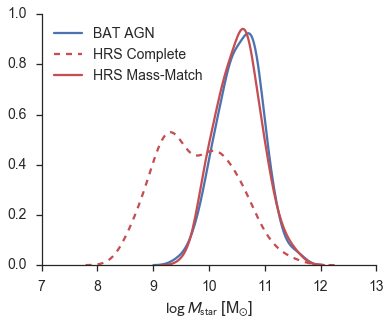

In [13]:
#fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
fig = plt.figure(figsize=(6, 4.5))
ax = fig.add_subplot(111)
sn.kdeplot(bat_casey['Mstar'], label=r'BAT AGN')
sn.kdeplot(hrs_info['logMstart'].dropna(), label='HRS Complete', color='r', linestyle='dashed')
sn.kdeplot(hrs_mass_select['Mstar'], label='HRS Mass-Match', color='r')
sn.despine()
ax.set_xlabel(r'$\log\,M_{\rm star}$ [M$_{\odot}$]')
ax.legend(loc='upper left')
fig.savefig('/Users/ttshimiz/Dropbox/Research/Thesis/Dissertation/presentation/stellar_mass_comp_hrs_match.pdf', bbox_inches='tight')

In [74]:
mass_select_hrs

,BAT Mstar,HRS ID,HRS Mstar
Name,,,
2MASXJ00253292+6821442,10.426497,114,10.51
2MASXJ01064523+0638015,10.812798,211,10.8
2MASXJ03534246+3714077,9.889120,57,9.81
2MASXJ04440903+2813003,10.829984,220,10.94
2MASXJ05054575-2351139,10.043630,215,9.92
2MASXJ06411806+3249313,10.140572,46,10.28
2MASXJ07595347+2323241,10.824176,122,10.71
2MASXJ09043699+5536025,9.967949,15,10
2MASXJ12005792+0648226,10.927208,97,11
